In [ ]:
def regression_model_setup():
  class EfficientNet9ChannelsModel(nn.Module):
        def __init__(self, pretrained=True):
            super(EfficientNet9ChannelsModel, self).__init__()
            # Load the pre-trained EfficientNet model
            self.efficientnet = models.efficientnet_b0(pretrained=pretrained)

            # Modify the first convolution layer to accept 3 input channels
            self.efficientnet.features[0][0] = nn.Conv2d(
                3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
            )

            # for param in self.efficientnet.parameters():
            #     param.requires_grad = False

            self.dropout = nn.Dropout(p=0.5)

            # Modify the classifier to output 1 value (for regression)
            self.efficientnet.classifier = nn.Sequential(
                nn.Linear(self.efficientnet.classifier[1].in_features, 1)
            )

            # for param in self.efficientnet.classifier.parameters():
            #     param.requires_grad = True

        def forward(self, x):
            x = self.efficientnet.features(x)
            x = self.efficientnet.avgpool(x)  # Use the pre-defined avgpool
            x = torch.flatten(x, 1)
            x = self.dropout(x)
            x = self.efficientnet.classifier(x)
            return x

  # class MobileNet9ChannelsModel(nn.Module):
  #   def __init__(self, pretrained=True):
  #       super(MobileNet9ChannelsModel, self).__init__()
  #       # Load the pre-trained MobileNetV2 model
  #       self.mobilenet = models.mobilenet_v2(pretrained=pretrained)

  #       self.mobilenet.features[0][0] = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

  #       self.mobilenet.classifier[1] = nn.Linear(self.mobilenet.classifier[1].in_features, 1)

  #   def forward(self, x):
  #       return self.mobilenet(x)

  model = EfficientNet9ChannelsModel(pretrained=True) #MobileNet9ChannelsModel(pretrained=True)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
  #filter(lambda p: p.requires_grad, model.parameters())
  #scheduler = StepLR(optimizer, step_size=5, gamma=0.1) #ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

  return model, criterion, optimizer#, scheduler

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            inputs = inputs.float()
            targets = targets.float()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                inputs = inputs.float()
                targets = targets.float()

                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets)
                val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        print(f"Validation Loss: {val_loss:.4f}")
        #scheduler.step()
    torch.save(model.state_dict(), '/content/drive/MyDrive/AI_ML_Project/Right_Fingernail/regression_model.pth')
    torch.save({'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}, '/content/drive/MyDrive/AI_ML_Project/Right_Fingernail/regression_model_train.pth')


In [ ]:
def test_model(model, test_loader, criterion, tolerance=0.5, display_samples=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    test_loss = 0.0
    all_targets = []
    all_predictions = []
    sample_count = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            inputs = inputs.float()
            targets = targets.float()

            outputs = model(inputs)
            predictions = outputs.view(-1) #squeeze()

            loss = criterion(predictions, targets)
            test_loss += loss.item()

            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

            if sample_count < display_samples:
                for i in range(len(targets)):
                    print(f"Sample {sample_count + 1}:")
                    print(f"  Predicted: {predictions[i].item():.4f}")
                    print(f"  Actual:    {targets[i].item():.4f}")
                    sample_count += 1
                    if sample_count >= display_samples:
                        break

    plt.scatter(all_targets, all_predictions, color='blue', label='Predicted vs Actual')
    plt.plot([min(all_targets), max(all_targets)], [min(all_targets), max(all_targets)], color='red', linestyle='--', label='Perfect Prediction Line')
    plt.title("Regression: Actual vs Predicted Hb Values")
    plt.xlabel("Actual Hb Values")
    plt.ylabel("Predicted Hb Values")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate metrics
    mae = mean_absolute_error(all_targets, all_predictions)
    mse = mean_squared_error(all_targets, all_predictions)
    rmse = torch.sqrt(torch.tensor(mse))
    r2 = r2_score(all_targets, all_predictions)

    # Display results
    print(f"\nTest Loss: {test_loss / len(test_loader):.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared (R²): {r2:.4f}")

    return {"mae": mae, "mse": mse, "rmse": rmse, "r2": r2}

In [ ]:
!pip install ultralytics

from google.colab import drive
from ultralytics import YOLO
import pandas as pd
import torch
from torchvision import transforms
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.model_selection import train_test_split
import zipfile
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset
import random
import numpy as np
import torch
from torchvision import transforms


drive.mount('/content/drive')

train_data = torch.load('/content/drive/MyDrive/AI_ML_Project/Right_Fingernail/train_data_orig.pt')
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)

val_data = torch.load('/content/drive/MyDrive/AI_ML_Project/Right_Fingernail/val_data_orig.pt')
val_loader = torch.utils.data.DataLoader(val_data, batch_size=16, shuffle=False)

test_data = torch.load('/content/drive/MyDrive/AI_ML_Project/Right_Fingernail/test_data_orig.pt')
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/20], Loss: 61.4418
Validation Loss: 52.8836
Epoch [2/20], Loss: 7.6564
Validation Loss: 37.5203
Epoch [3/20], Loss: 6.0213
Validation Loss: 13.7408
Epoch [4/20], Loss: 4.0263
Validation Loss: 4.6451
Epoch [5/20], Loss: 3.1777
Validation Loss: 5.0308
Epoch [6/20], Loss: 2.5165
Validation Loss: 4.6749
Epoch [7/20], Loss: 2.4143
Validation Loss: 4.5124
Epoch [8/20], Loss: 1.8523
Validation Loss: 6.5922
Epoch [9/20], Loss: 2.1735
Validation Loss: 4.4189
Epoch [10/20], Loss: 1.1963
Validation Loss: 4.2841
Epoch [11/20], Loss: 1.2220
Validation Loss: 4.5635
Epoch [12/20], Loss: 1.0193
Validation Loss: 4.0323
Epoch [13/20], Loss: 0.9256
Validation Loss: 4.1056
Epoch [14/20], Loss: 1.1428
Validation Loss: 4.1523
Epoch [15/20], Loss: 1.0707
Validation Loss: 3.9945
Epoch [16/20], Loss: 0.8886
Validation Loss: 5.6109
Epoch [17/20], Loss: 1.0861
Validation Loss: 4.7242
Epoch [18/20], Loss: 0.8563
Validation Loss: 3.9780
Epoch [19/20], Loss: 0.7847
Validation Loss: 4.9854
Epoch [20/20], Lo

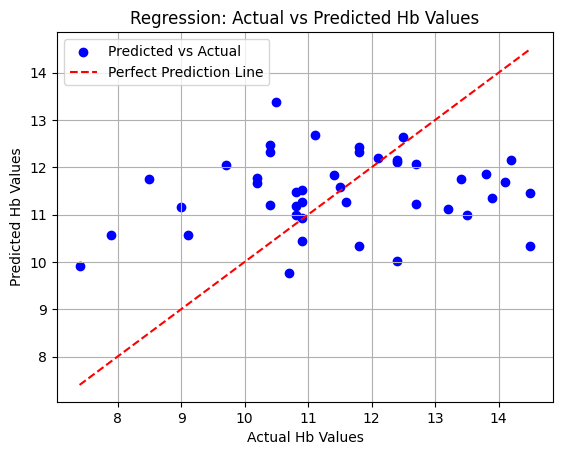


Test Loss: 3.2872
Mean Absolute Error (MAE): 1.4301
Mean Squared Error (MSE): 3.1249
Root Mean Squared Error (RMSE): 1.7677
R-squared (R²): -0.0640


In [ ]:
#from torch.optim.lr_scheduler import ReduceLROnPlateau
#from torch.optim.lr_scheduler import StepLR

regression_model, criterion, optimizer = regression_model_setup()
train_model(regression_model, train_loader, val_loader, criterion, optimizer, num_epochs=20)
metrics = test_model(regression_model, test_loader, criterion, display_samples=20)